# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [1]:
%pip install xarray zarr dask lightning matplotlib wandb cftime einops vizarr


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# lets visuzlize a zarr file
import vizarr
import zarr

In [3]:

import os
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
from lightning.pytorch.callbacks import EarlyStopping

### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [29]:
early_stopping = EarlyStopping(
    monitor='val/tas/rmse',  # You'll need to calculate and log val_rmse in your LightningModule
    min_delta=0.001,       # Minimum change in the monitored quantity to qualify as an improvement.
    patience=5,          # Stop after 5 epochs of no improvement
    verbose=True,
    mode='min'           # Assuming lower RMSE is better
)

In [30]:
config = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas"], 
        "target_member_id": 0, 
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360, 
        "batch_size": 64, 
        "num_workers": 0,
        "num_fft_freq_bins": 10, 
    },
    "model": { 
        "type": "unet", 
       #need hyperparams 
    },
    "training": {
        "lr": 1e-4, # MODIFIED: Set as per user's provided config
    },
    "trainer": {
        "max_epochs": 100, 
        "accelerator": "auto",
        "devices": "auto",
        "precision": 16, 
        "deterministic": True,
        "num_sanity_val_steps": 0,
        "callbacks": []
    },
    "seed": 42,
}


pl.seed_everything(config["seed"])
config["trainer"]["callbacks"].append(early_stopping)

Seed set to 42


### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [6]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**. 

We encourage you to build and experiment with your own models and ideas.


In [7]:
ds = xr.open_zarr(config["data"]["path"], consolidated=False, chunks={"time": 24})
# Add this line to print the number of member IDs
if 'member_id' in ds.coords:
    num_members = len(ds.coords['member_id'].values)
    print(f"Number of ensemble members: {num_members}")
else:
    print("The 'member_id' coordinate was not found in the dataset.")

Number of ensemble members: 3


In [8]:
class UNET
    Convolutional LSTM Cell.
    Adapted from various sources.
    """
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2 # Ensure same padding
        self.bias = bias

        # Convolution for combined inputs (input_t and h_t-1)
        # It computes all gates (input, forget, output, cell) in one go
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim, # 4 gates
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        """
        Forward pass of the ConvLSTM cell.
        Parameters
        ----------
        input_tensor: torch.Tensor
            Input tensor for the current time step (b, c, h, w)
        cur_state: tuple
            Tuple containing the previous hidden state (h_cur) and cell state (c_cur)
        Returns
        -------
        h_next, c_next: torch.Tensor
            Next hidden state and cell state
        """
        h_cur, c_cur = cur_state
        
        # Concatenate input and hidden state
        combined = torch.cat([input_tensor, h_cur], dim=1)  # (b, input_dim + hidden_dim, h, w)
        
        combined_conv = self.conv(combined) # (b, 4 * hidden_dim, h, w)
        
        # Split the convoluted tensor into 4 parts for the 4 gates
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        
        # Apply activations
        i = torch.sigmoid(cc_i) # Input gate
        f = torch.sigmoid(cc_f) # Forget gate
        o = torch.sigmoid(cc_o) # Output gate
        g = torch.tanh(cc_g)    # Cell gate (candidate cell state)

        # Calculate next cell state and hidden state
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        """
        Initializes hidden state and cell state to zeros.
        Parameters
        ----------
        batch_size: int
            Batch size.
        image_size: (int, int)
            Height and width of the image.
        Returns
        -------
        (h, c): tuple of torch.Tensor
            Initial hidden and cell states.
        """
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTMModel(nn.Module):
    def __init__(self, in_channels_effective, cnn_encoder_channels, cnn_encoder_kernels,
                 conv_lstm_input_dim, conv_lstm_hidden_dims, conv_lstm_kernel_sizes,
                 cnn_decoder_channels, cnn_decoder_kernels, final_decoder_kernel, # Added final_decoder_kernel here
                 img_h, img_w, out_channels):
        super(ConvLSTMModel, self).__init__()

        self.img_h = img_h
        self.img_w = img_w
        self.out_channels = out_channels

        # CNN Encoder
        encoder_layers = []
        current_channels = in_channels_effective
        for i, out_ch in enumerate(cnn_encoder_channels):
            encoder_layers.append(
                nn.Conv2d(in_channels=current_channels, 
                          out_channels=out_ch, 
                          kernel_size=cnn_encoder_kernels[i], 
                          padding=cnn_encoder_kernels[i]//2) 
            )
            encoder_layers.append(nn.ReLU(inplace=True))
            current_channels = out_ch
        self.encoder = nn.Sequential(*encoder_layers)

        # ConvLSTM Layer(s)
        self.conv_lstm_cells = nn.ModuleList()
        lstm_input_dim_current = conv_lstm_input_dim 
        
        if not isinstance(conv_lstm_hidden_dims, list):
            conv_lstm_hidden_dims = [conv_lstm_hidden_dims] 
        if not isinstance(conv_lstm_kernel_sizes, list) or \
           (conv_lstm_kernel_sizes and not isinstance(conv_lstm_kernel_sizes[0], tuple)):
            conv_lstm_kernel_sizes = [conv_lstm_kernel_sizes] * len(conv_lstm_hidden_dims)


        for i in range(len(conv_lstm_hidden_dims)):
            self.conv_lstm_cells.append(
                ConvLSTMCell(input_dim=lstm_input_dim_current,
                             hidden_dim=conv_lstm_hidden_dims[i],
                             kernel_size=conv_lstm_kernel_sizes[i], 
                             bias=True)
            )
            lstm_input_dim_current = conv_lstm_hidden_dims[i] 

        # CNN Decoder
        decoder_layers = []
        current_channels_decoder = conv_lstm_hidden_dims[-1] 
        
        for i, out_ch in enumerate(cnn_decoder_channels): # Iterate through all specified decoder channels
            decoder_layers.append(
                nn.Conv2d(in_channels=current_channels_decoder,
                          out_channels=out_ch,
                          kernel_size=cnn_decoder_kernels[i],
                          padding=cnn_decoder_kernels[i]//2)
            )
            decoder_layers.append(nn.ReLU(inplace=True))
            current_channels_decoder = out_ch
        
        # Final decoder layer to get to out_channels
        decoder_layers.append(
            nn.Conv2d(in_channels=current_channels_decoder,
                      out_channels=self.out_channels, 
                      kernel_size=final_decoder_kernel, # Use the dedicated kernel size
                      padding=final_decoder_kernel//2)
        )
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.h_states = None
        self.c_states = None


    def _init_hidden_states(self, batch_size, device):
        """Initializes hidden states for all LSTM layers."""
        self.h_states = []
        self.c_states = []
        image_size_for_lstm = (self.img_h, self.img_w) 

        for cell in self.conv_lstm_cells:
            h, c = cell.init_hidden(batch_size, image_size_for_lstm)
            self.h_states.append(h.to(device))
            self.c_states.append(c.to(device))

    def forward(self, x, hidden_state_tuple=None): # Renamed for clarity
        """
        Processes a single time-step input.
        x: (batch, in_channels_effective, height, width)
        hidden_state_tuple: Optional tuple of (list_of_h_states, list_of_c_states) for all LSTM layers.
                            If None, states are initialized. This is for one time step.
        """
        batch_size = x.size(0)
        device = x.device

        # 1. CNN Encoder
        encoded_x = self.encoder(x) 

        # 2. ConvLSTM Layer(s)
        # Initialize hidden states if not provided or if batch size changed
        # For single time-step processing managed by LightningModule, 
        # we typically re-initialize states for each batch.
        # If you were to process sequences within this model, state management would differ.
        
        # Always re-initialize for each forward pass if processing independent time steps
        # This ensures that each sample in the batch starts with a fresh LSTM state.
        # If your ClimateEmulationModule is designed to pass states for sequential data,
        # then you'd use the hidden_state_tuple.
        # For now, assuming independent samples per batch call:
        self._init_hidden_states(batch_size, device) 
        current_h_states = self.h_states
        current_c_states = self.c_states

        # If you want to enable stateful processing across calls (e.g., for sequences handled outside)
        # you would uncomment the below and pass the states appropriately.
        # if hidden_state_tuple is None:
        #     self._init_hidden_states(batch_size, device)
        #     current_h_states = self.h_states
        #     current_c_states = self.c_states
        # else:
        #     current_h_states, current_c_states = hidden_state_tuple
        #     current_h_states = [h.to(device) for h in current_h_states]
        #     current_c_states = [c.to(device) for c in current_c_states]

        lstm_input = encoded_x
        next_h_states_list = [] # Store next states for all layers
        next_c_states_list = []

        for i, cell in enumerate(self.conv_lstm_cells):
            h_next_layer, c_next_layer = cell(input_tensor=lstm_input,
                                              cur_state=(current_h_states[i], current_c_states[i]))
            next_h_states_list.append(h_next_layer)
            next_c_states_list.append(c_next_layer)
            lstm_input = h_next_layer # Output of current LSTM layer is input to next

        # Update instance states (optional if you don't need them outside this call for single-step)
        self.h_states = next_h_states_list 
        self.c_states = next_c_states_list

        # 3. CNN Decoder
        # Use the output (hidden state) of the last LSTM layer
        output = self.decoder(self.h_states[-1]) 

        # MODIFIED: Return only the output tensor
        return output

### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [9]:
class Normalizer:
    def __init__(self, log_transform_input=False, log_transform_output=False):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None
        self.log_transform_input = log_transform_input
        self.log_transform_output = log_transform_output
        self.epsilon = 1e-10  # small constant to avoid log(0)

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            if self.log_transform_input:
                data = np.log(data + self.epsilon)
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            if self.log_transform_output:
                data = np.log(data + self.epsilon)
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        denormalized = data * self.std_out + self.mean_out
        if self.log_transform_output:
            return np.exp(denormalized) - self.epsilon
        return denormalized

    def inverse_transform_input(self, data):
        denormalized = data * self.std_in + self.mean_in
        if self.log_transform_input:
            return np.exp(denormalized) - self.epsilon
        return denormalized

### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [31]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples (will trigger Dask compute)...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()
        
        print("Dask compute finished.")
        print(f"Initial inputs_np shape: {inputs_np.shape}, outputs_np shape: {outputs_np.shape}")
        
        self.inputs = torch.from_numpy(inputs_np).float()


        self.outputs = torch.from_numpy(outputs_np).float()


            
        print(f"\nDataset creation complete. Final Input shape: {self.inputs.shape}, Final Output shape: {self.outputs.shape}")


    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

# get_lat_weights should be globally available or passed if needed
# def get_lat_weights(latitude_values): ... (defined in config cell)

class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        num_fft_freq_bins, # K
        test_months=360,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.num_fft_freq_bins = num_fft_freq_bins
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def _load_and_process_ssp(self, ssp, ds, spatial_template):
        C_orig = len(self.input_vars)
        H, W = spatial_template.shape[-2], spatial_template.shape[-1]
        K = self.num_fft_freq_bins

        input_dask_orig_list = []
        for var_name in self.input_vars:
            da_var = ds[var_name].sel(ssp=ssp)
            if "latitude" in da_var.dims:
                da_var = da_var.rename({"latitude": "y", "longitude": "x"})
            if "member_id" in da_var.dims:
                da_var = da_var.sel(member_id=self.target_member_id)
            if set(da_var.dims) == {"time"}:
                da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
            input_dask_orig_list.append(da_var.data)
        
        x_orig_ssp = da.stack(input_dask_orig_list, axis=1) # [Time_ssp, C_orig, H, W]
        
        # MODIFIED: NaN handling before FFT using da.where
        x_orig_ssp_filled = da.where(da.isnan(x_orig_ssp), 0.0, x_orig_ssp)
        
        fft_coeffs_ssp = da.fft.rfft(x_orig_ssp_filled, axis=0)
        fft_magnitudes_ssp = da.absolute(fft_coeffs_ssp)   # Shape: [Freq, C_orig, H, W]
        
        actual_K = min(K, fft_magnitudes_ssp.shape[0])
        if K > fft_magnitudes_ssp.shape[0]:
            print(f"Warning: Requested K={K} bins, but only {fft_magnitudes_ssp.shape[0]} available for SSP {ssp}. Using K={actual_K}.")
        
        selected_fft_magnitudes = fft_magnitudes_ssp[:actual_K, :, :, :]
        
        C_fft = C_orig * actual_K
        if C_fft == 0 and actual_K == 0: 
             x_combined_ssp = x_orig_ssp_filled 
        else:
            static_fft_features_ssp = selected_fft_magnitudes.transpose((1, 0, 2, 3)).reshape((C_fft, H, W))
            Time_ssp = x_orig_ssp_filled.shape[0] 
            static_fft_broadcasted_ssp = da.broadcast_to(
                static_fft_features_ssp.reshape((1, C_fft, H, W)),
                (Time_ssp, C_fft, H, W)
            )
            x_combined_ssp = da.concatenate([x_orig_ssp_filled, static_fft_broadcasted_ssp], axis=1)

        output_dask_list = []
        for var_name in self.output_vars:
            da_out = ds[var_name].sel(ssp=ssp)
            if "latitude" in da_out.dims:
                da_out = da_out.rename({"latitude": "y", "longitude": "x"})
            if "member_id" in da_out.dims:
                da_out = da_out.mean("member_id", skipna=True)
            output_dask_list.append(da_out.data)
        y_ssp = da.stack(output_dask_list, axis=1)

        # MODIFIED: NaN handling for outputs using da.where
        y_ssp = da.where(da.isnan(y_ssp), 0.0, y_ssp)

        return x_combined_ssp, y_ssp

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": "auto"})
        
        template_ssp = self.train_ssps[0]
        template_member_id = self.target_member_id if 'member_id' in ds["rsdt"].coords else None
        
        if template_member_id is not None:
            spatial_template_source = ds["rsdt"].sel(ssp=template_ssp, member_id=template_member_id)
        else:
            spatial_template_source = ds["rsdt"].sel(ssp=template_ssp)
            
        spatial_template = spatial_template_source.isel(time=0, drop=True)
        if "latitude" in spatial_template.dims:
            spatial_template = spatial_template.rename({"latitude": "y", "longitude": "x"})

        train_input_list, train_output_list = [], []
        val_input_da, val_output_da = None, None

        for ssp in self.train_ssps:
            x_combined_ssp, y_ssp = self._load_and_process_ssp(ssp, ds, spatial_template)
            if ssp == "ssp370":
                val_input_da = x_combined_ssp[-self.test_months:]
                val_output_da = y_ssp[-self.test_months:]
                train_input_list.append(x_combined_ssp[:-self.test_months])
                train_output_list.append(y_ssp[:-self.test_months])
            else:
                train_input_list.append(x_combined_ssp)
                train_output_list.append(y_ssp)

        train_input_da = da.concatenate(train_input_list, axis=0)
        train_output_da = da.concatenate(train_output_list, axis=0)
        
        input_mean = da.mean(train_input_da, axis=(0, 2, 3), keepdims=True).compute()
        input_std = da.std(train_input_da, axis=(0, 2, 3), keepdims=True).compute()
        self.normalizer.set_input_statistics(mean=input_mean, std=input_std)
        
        output_mean = da.mean(train_output_da, axis=(0, 2, 3), keepdims=True).compute()
        output_std = da.std(train_output_da, axis=(0, 2, 3), keepdims=True).compute()
        self.normalizer.set_output_statistics(mean=output_mean, std=output_std)

        train_input_norm_da = self.normalizer.normalize(train_input_da, "input")
        train_output_norm_da = self.normalizer.normalize(train_output_da, "output")
        val_input_norm_da = self.normalizer.normalize(val_input_da, "input")
        val_output_norm_da = self.normalizer.normalize(val_output_da, "output")
        
        x_test_combined_da, y_test_da = self._load_and_process_ssp(self.test_ssp, ds, spatial_template)
        x_test_combined_da = x_test_combined_da[-self.test_months:]
        y_test_da = y_test_da[-self.test_months:]
        test_input_norm_da = self.normalizer.normalize(x_test_combined_da, "input")

        self.train_dataset = ClimateDataset(train_input_norm_da, train_output_norm_da)
        self.val_dataset = ClimateDataset(val_input_norm_da, val_output_norm_da)
        self.test_dataset = ClimateDataset(test_input_norm_da, y_test_da, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True, 
                          persistent_workers=(self.num_workers > 0))

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True,
                          persistent_workers=(self.num_workers > 0))

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True,
                          persistent_workers=(self.num_workers > 0))

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

In [32]:
cdm = ClimateDataModule(
    path=config["data"]["path"],
    input_vars=config["data"]["input_vars"],
    output_vars=config["data"]["output_vars"],
    train_ssps=config["data"]["train_ssps"],
    test_ssp=config["data"]["test_ssp"],
    target_member_id=config["data"]["target_member_id"],
    num_fft_freq_bins=config["data"]["num_fft_freq_bins"],
    test_months=config["data"]["test_months"],
    batch_size=config["data"]["batch_size"],
    num_workers=config["data"]["num_workers"],
    seed=config["seed"],
)
cdm.prepare_data()
cdm.setup()
# print the shape of train, validation, and test datasets
print(f"Train dataset shape: {len(cdm.train_dataset)}, {cdm.train_dataset.inputs.shape}")
print(f"Validation dataset shape: {cdm.val_dataset.inputs.shape}, {cdm.val_dataset.outputs.shape}")
print(f"Test dataset shape: {cdm.test_dataset.inputs.shape}, {cdm.test_dataset.outputs.shape}")



Creating dataset with 2703 samples (will trigger Dask compute)...
Dask compute finished.
Initial inputs_np shape: (2703, 55, 48, 72), outputs_np shape: (2703, 1, 48, 72)

Dataset creation complete. Final Input shape: torch.Size([2703, 55, 48, 72]), Final Output shape: torch.Size([2703, 1, 48, 72])
Creating dataset with 360 samples (will trigger Dask compute)...
Dask compute finished.
Initial inputs_np shape: (360, 55, 48, 72), outputs_np shape: (360, 1, 48, 72)

Dataset creation complete. Final Input shape: torch.Size([360, 55, 48, 72]), Final Output shape: torch.Size([360, 1, 48, 72])
Creating dataset with 360 samples (will trigger Dask compute)...
Dask compute finished.
Initial inputs_np shape: (360, 55, 48, 72), outputs_np shape: (360, 1, 48, 72)

Dataset creation complete. Final Input shape: torch.Size([360, 55, 48, 72]), Final Output shape: torch.Size([360, 1, 48, 72])
Train dataset shape: 2703, torch.Size([2703, 55, 48, 72])
Validation dataset shape: torch.Size([360, 55, 48, 72])

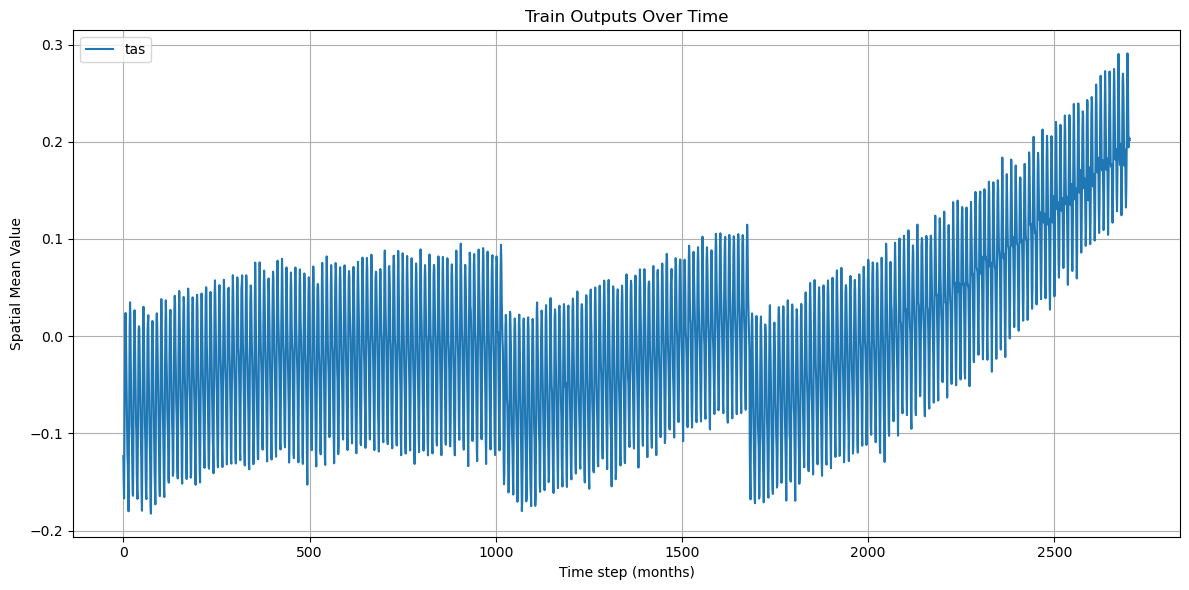

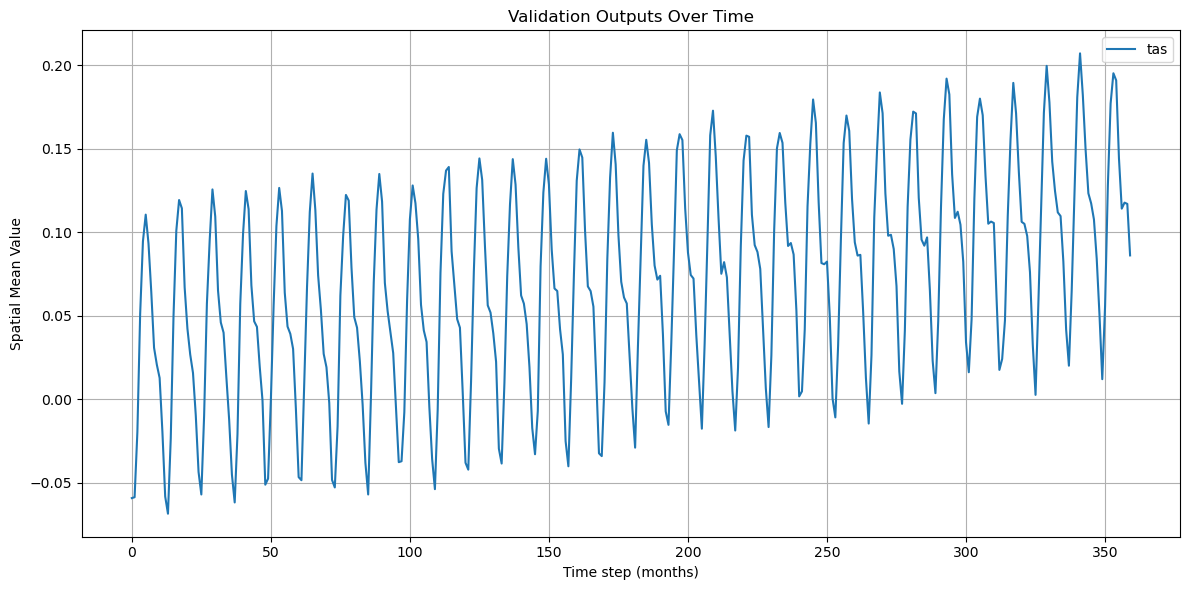

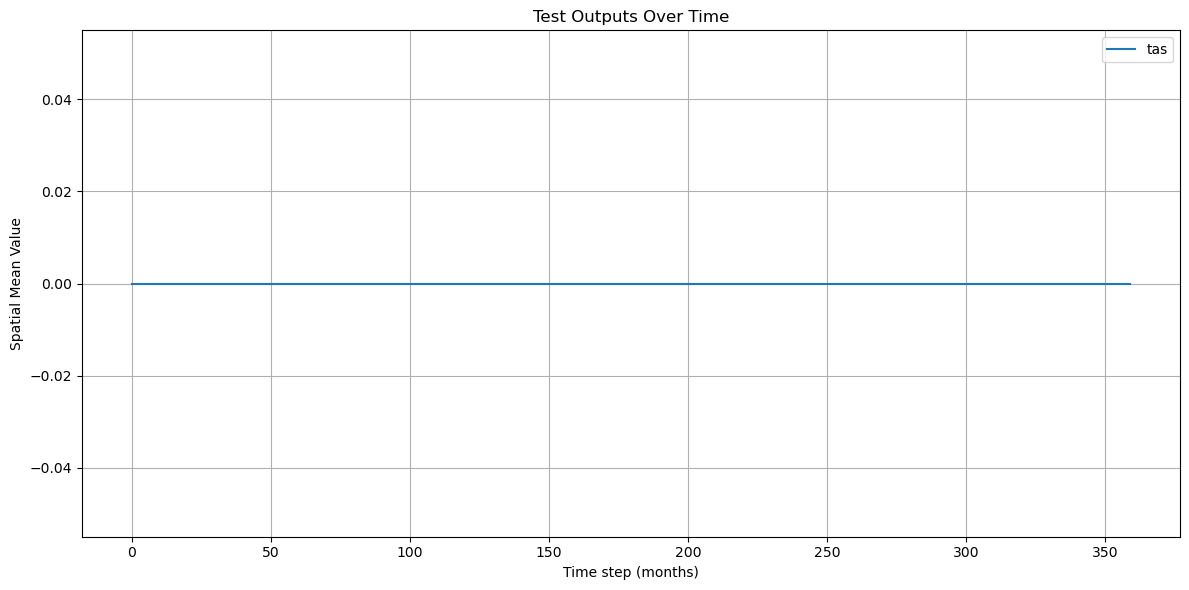

In [33]:
import matplotlib.pyplot as plt
import torch

def plot_output_over_time(outputs, output_var_names, title_prefix="Train"):
    """
    Plot the spatial average of each output variable over time.
    
    Args:
        outputs (torch.Tensor): shape [T, C, H, W]
        output_var_names (list): Names of output variables, length C
        title_prefix (str): "Train", "Val", or "Test"
    """
    if outputs.dim() != 4:
        raise ValueError("Expected outputs with shape [T, C, H, W]")
    
    T, C, H, W = outputs.shape
    outputs_np = outputs.numpy()

    # Compute spatial average (mean over H and W) for each time step and variable
    spatial_means = outputs_np.mean(axis=(2, 3))  # shape: [T, C]

    # Plot each output variable's mean over time
    plt.figure(figsize=(12, 6))
    for i in range(C):
        plt.plot(spatial_means[:, i], label=output_var_names[i])
    
    plt.xlabel("Time step (months)")
    plt.ylabel("Spatial Mean Value")
    plt.title(f"{title_prefix} Outputs Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_output_over_time(cdm.train_dataset.outputs, cdm.output_vars, title_prefix="Train")
plot_output_over_time(cdm.val_dataset.outputs, cdm.output_vars, title_prefix="Validation")
plot_output_over_time(cdm.test_dataset.outputs, cdm.output_vars, title_prefix="Test")

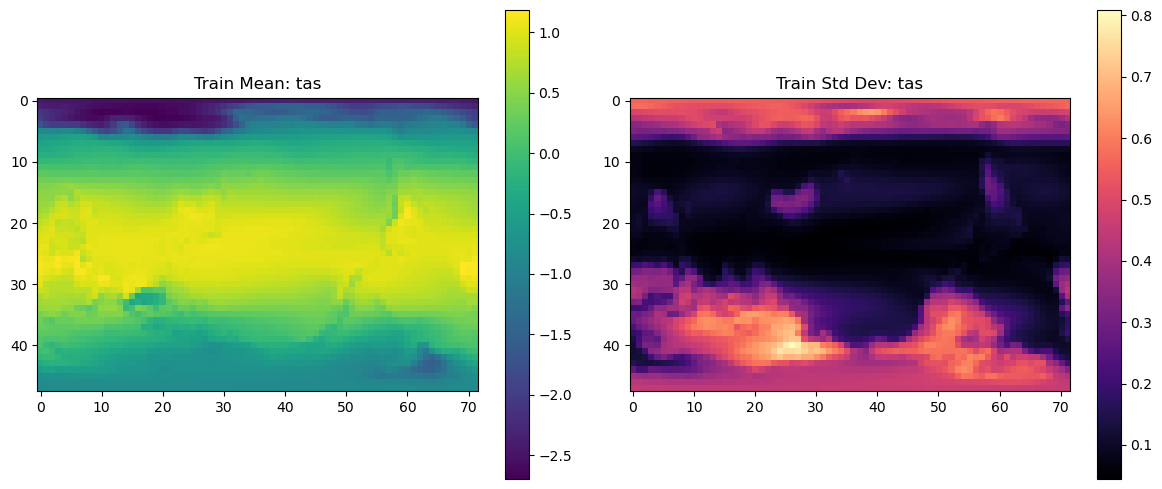

In [34]:
import matplotlib.pyplot as plt
import torch

def plot_spatial_stats(outputs, output_var_names, title_prefix="Train"):
    """
    Plot spatial mean and standard deviation maps for each output variable.

    Args:
        outputs (torch.Tensor): shape [T, C, H, W]
        output_var_names (list): Names of output variables
        title_prefix (str): e.g., "Train", "Validation", "Test"
    """
    if outputs.dim() != 4:
        raise ValueError("Expected outputs with shape [T, C, H, W]")

    T, C, H, W = outputs.shape
    outputs_np = outputs.numpy()

    spatial_mean = outputs_np.mean(axis=0)  # shape: [C, H, W]
    spatial_std = outputs_np.std(axis=0)    # shape: [C, H, W]

    for i in range(C):
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        
        im0 = axs[0].imshow(spatial_mean[i], cmap='viridis')
        axs[0].set_title(f"{title_prefix} Mean: {output_var_names[i]}")
        plt.colorbar(im0, ax=axs[0])

        im1 = axs[1].imshow(spatial_std[i], cmap='magma')
        axs[1].set_title(f"{title_prefix} Std Dev: {output_var_names[i]}")
        plt.colorbar(im1, ax=axs[1])

        plt.tight_layout()
        plt.show()

# Example usage:
plot_spatial_stats(cdm.train_dataset.outputs, cdm.output_vars, title_prefix="Train")


# Lets visualize the distribution of output variables

In [35]:
out_vars = cdm.output_vars
in_vars = cdm.input_vars
print(f"Input variables: {in_vars}")
print(f"Output variables: {out_vars}")

Input variables: ['CO2', 'SO2', 'CH4', 'BC', 'rsdt']
Output variables: ['tas']


In [36]:
train_output = cdm.train_dataset.outputs
print(f"Train output shape: {train_output.shape}")

Train output shape: torch.Size([2703, 1, 48, 72])


In [37]:
train_input = cdm.train_dataset.inputs
print(f"Train input shape: {train_input.shape}")

Train input shape: torch.Size([2703, 55, 48, 72])


In [38]:
print(in_vars)
train_input = cdm.train_dataset.inputs
train_input.shape

['CO2', 'SO2', 'CH4', 'BC', 'rsdt']


torch.Size([2703, 55, 48, 72])

In [39]:
print(out_vars)

['tas']


## Here i used ai to write a loop to generate heatmaps

### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [1]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
import pdb
import torch.nn.functional as F
from lightning.pytorch.callbacks import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau # Make sure this is imported

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model'])
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []
        self.train_losses = [] # Initialize list to store training losses
        self.val_losses = []   # Initialize list to store validation losses

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train/loss", loss)
        self.train_losses.append(loss.item()) # Append training loss for plotting
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss)
        self.val_losses.append(loss.item()) # Append validation loss for plotting

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)
        return loss

    def on_validation_epoch_end(self):
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=3,
                verbose=True,
                min_lr=1e-7,
                monitor='val/pr/rmse'
            ),
            'interval': 'epoch',
            'frequency': 1,
            'monitor': 'val/pr/rmse'
        }
        return [optimizer], [scheduler]

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [41]:
model = ConvLSTMModel(
    in_channels_effective=config["model"]["in_channels_effective"],
    cnn_encoder_channels=config["model"]["cnn_encoder_channels"],
    cnn_encoder_kernels=config["model"]["cnn_encoder_kernels"],
    conv_lstm_input_dim=config["model"]["conv_lstm_input_dim"],
    conv_lstm_hidden_dims=config["model"]["conv_lstm_hidden_dims"],
    conv_lstm_kernel_sizes=config["model"]["conv_lstm_kernel_sizes"],
    cnn_decoder_channels=config["model"]["cnn_decoder_channels"],
    cnn_decoder_kernels=config["model"]["cnn_decoder_kernels"],
    final_decoder_kernel=config["model"]["final_decoder_kernel"],
    img_h=config["model"]["img_size_h"],
    img_w=config["model"]["img_size_w"],
    out_channels=config["model"]["out_channels"]
)

# Instantiate the ClimateEmulationModule (LightningModule)
# This wraps your PyTorch model (ConvLSTMModel) and adds training/validation/test logic
climate_model = ClimateEmulationModule( # Renamed to avoid conflict if 'climate_model' is used elsewhere
    model=model,
    learning_rate=config["training"]["lr"],
)

# Instantiate the PyTorch Lightning Trainer
# Parameters are taken from the config['trainer'] dictionary
trainer = pl.Trainer(
    max_epochs=config["trainer"]["max_epochs"],
    accelerator=config["trainer"]["accelerator"],
    devices=config["trainer"]["devices"],
    precision=config["trainer"]["precision"],
    deterministic=config["trainer"]["deterministic"],
    num_sanity_val_steps=config["trainer"]["num_sanity_val_steps"],
    callbacks=config["trainer"]["callbacks"], # This should include early_stopping
    # logger=logger, # Uncomment and set up a logger (e.g., TensorBoardLogger or WandbLogger) if desired
)



/home/dpachchigar/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [42]:
# Train the model
print("Starting training...")
trainer.fit(climate_model, cdm)
print("Training finished.")

Starting training...
Creating dataset with 2703 samples (will trigger Dask compute)...
Dask compute finished.
Initial inputs_np shape: (2703, 55, 48, 72), outputs_np shape: (2703, 1, 48, 72)

Dataset creation complete. Final Input shape: torch.Size([2703, 55, 48, 72]), Final Output shape: torch.Size([2703, 1, 48, 72])
Creating dataset with 360 samples (will trigger Dask compute)...
Dask compute finished.
Initial inputs_np shape: (360, 55, 48, 72), outputs_np shape: (360, 1, 48, 72)

Dataset creation complete. Final Input shape: torch.Size([360, 55, 48, 72]), Final Output shape: torch.Size([360, 1, 48, 72])
Creating dataset with 360 samples (will trigger Dask compute)...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | model     | ConvLSTMModel | 11.8 M | train
1 | criterion | MSELoss       | 0      | train
----------------------------------------------------
11.8 M    Trainable params
0         Non-trainable params
11.8 M    Total params
47.328    Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Dask compute finished.
Initial inputs_np shape: (360, 55, 48, 72), outputs_np shape: (360, 1, 48, 72)

Dataset creation complete. Final Input shape: torch.Size([360, 55, 48, 72]), Final Output shape: torch.Size([360, 1, 48, 72])


/home/dpachchigar/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.
/home/dpachchigar/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved. New best score: 5.523


[VAL] tas: RMSE=5.5233, Time-Mean RMSE=4.1247, Time-Stddev MAE=1.8903


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.767 >= min_delta = 0.001. New best score: 4.757


[VAL] tas: RMSE=4.7568, Time-Mean RMSE=3.2391, Time-Stddev MAE=1.5796


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.165 >= min_delta = 0.001. New best score: 4.592


[VAL] tas: RMSE=4.5919, Time-Mean RMSE=3.1068, Time-Stddev MAE=1.4092


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.068 >= min_delta = 0.001. New best score: 4.524


[VAL] tas: RMSE=4.5239, Time-Mean RMSE=3.0558, Time-Stddev MAE=1.2505


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.120 >= min_delta = 0.001. New best score: 4.404


[VAL] tas: RMSE=4.4037, Time-Mean RMSE=2.9149, Time-Stddev MAE=1.2483


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4887, Time-Mean RMSE=3.0706, Time-Stddev MAE=1.1810


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.062 >= min_delta = 0.001. New best score: 4.342


[VAL] tas: RMSE=4.3420, Time-Mean RMSE=2.8883, Time-Stddev MAE=1.3577


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.033 >= min_delta = 0.001. New best score: 4.309


[VAL] tas: RMSE=4.3090, Time-Mean RMSE=2.8798, Time-Stddev MAE=1.0838


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.090 >= min_delta = 0.001. New best score: 4.219


[VAL] tas: RMSE=4.2185, Time-Mean RMSE=2.7903, Time-Stddev MAE=1.1477


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3033, Time-Mean RMSE=2.8538, Time-Stddev MAE=1.4800


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.080 >= min_delta = 0.001. New best score: 4.138


[VAL] tas: RMSE=4.1385, Time-Mean RMSE=2.6992, Time-Stddev MAE=1.1822


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1806, Time-Mean RMSE=2.7505, Time-Stddev MAE=1.1804


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.051 >= min_delta = 0.001. New best score: 4.087


[VAL] tas: RMSE=4.0874, Time-Mean RMSE=2.6615, Time-Stddev MAE=1.1862


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.031 >= min_delta = 0.001. New best score: 4.056


[VAL] tas: RMSE=4.0560, Time-Mean RMSE=2.6318, Time-Stddev MAE=1.1232


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.0558, Time-Mean RMSE=2.6312, Time-Stddev MAE=1.0212


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.036 >= min_delta = 0.001. New best score: 4.020


[VAL] tas: RMSE=4.0201, Time-Mean RMSE=2.5780, Time-Stddev MAE=0.9606


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.033 >= min_delta = 0.001. New best score: 3.987


[VAL] tas: RMSE=3.9870, Time-Mean RMSE=2.5926, Time-Stddev MAE=1.1000


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.0189, Time-Mean RMSE=2.6421, Time-Stddev MAE=1.1179


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1433, Time-Mean RMSE=2.8129, Time-Stddev MAE=0.9974


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.061 >= min_delta = 0.001. New best score: 3.926


[VAL] tas: RMSE=3.9257, Time-Mean RMSE=2.5289, Time-Stddev MAE=1.2664


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.034 >= min_delta = 0.001. New best score: 3.892


[VAL] tas: RMSE=3.8919, Time-Mean RMSE=2.4977, Time-Stddev MAE=1.1221


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.9164, Time-Mean RMSE=2.6133, Time-Stddev MAE=1.2701


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.130 >= min_delta = 0.001. New best score: 3.762


[VAL] tas: RMSE=3.7618, Time-Mean RMSE=2.4060, Time-Stddev MAE=0.9664


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.047 >= min_delta = 0.001. New best score: 3.715


[VAL] tas: RMSE=3.7145, Time-Mean RMSE=2.4370, Time-Stddev MAE=1.0134


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.017 >= min_delta = 0.001. New best score: 3.698


[VAL] tas: RMSE=3.6977, Time-Mean RMSE=2.3896, Time-Stddev MAE=0.9523


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.078 >= min_delta = 0.001. New best score: 3.619


[VAL] tas: RMSE=3.6195, Time-Mean RMSE=2.3744, Time-Stddev MAE=1.1610


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.042 >= min_delta = 0.001. New best score: 3.578


[VAL] tas: RMSE=3.5777, Time-Mean RMSE=2.3858, Time-Stddev MAE=1.1050


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.6587, Time-Mean RMSE=2.4736, Time-Stddev MAE=1.1991


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.110 >= min_delta = 0.001. New best score: 3.468


[VAL] tas: RMSE=3.4676, Time-Mean RMSE=2.3282, Time-Stddev MAE=0.9559


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.5010, Time-Mean RMSE=2.3959, Time-Stddev MAE=1.0673


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.6167, Time-Mean RMSE=2.3695, Time-Stddev MAE=0.9473


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.134 >= min_delta = 0.001. New best score: 3.333


[VAL] tas: RMSE=3.3335, Time-Mean RMSE=2.2392, Time-Stddev MAE=0.9978


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.004 >= min_delta = 0.001. New best score: 3.330


[VAL] tas: RMSE=3.3297, Time-Mean RMSE=2.3013, Time-Stddev MAE=0.9673


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.132 >= min_delta = 0.001. New best score: 3.198


[VAL] tas: RMSE=3.1981, Time-Mean RMSE=2.1504, Time-Stddev MAE=0.8683


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.2301, Time-Mean RMSE=2.1961, Time-Stddev MAE=0.8149


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.175 >= min_delta = 0.001. New best score: 3.023


[VAL] tas: RMSE=3.0234, Time-Mean RMSE=1.9547, Time-Stddev MAE=1.0190


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.0780, Time-Mean RMSE=2.0961, Time-Stddev MAE=0.9091


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.107 >= min_delta = 0.001. New best score: 2.916


[VAL] tas: RMSE=2.9159, Time-Mean RMSE=1.7683, Time-Stddev MAE=0.7645


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.208 >= min_delta = 0.001. New best score: 2.708


[VAL] tas: RMSE=2.7082, Time-Mean RMSE=1.5781, Time-Stddev MAE=0.8655


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.078 >= min_delta = 0.001. New best score: 2.630


[VAL] tas: RMSE=2.6299, Time-Mean RMSE=1.4717, Time-Stddev MAE=0.8364


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.229 >= min_delta = 0.001. New best score: 2.401


[VAL] tas: RMSE=2.4006, Time-Mean RMSE=1.1971, Time-Stddev MAE=0.7013


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.146 >= min_delta = 0.001. New best score: 2.254


[VAL] tas: RMSE=2.2544, Time-Mean RMSE=1.0390, Time-Stddev MAE=0.8536


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.2871, Time-Mean RMSE=1.1402, Time-Stddev MAE=0.7680


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.3334, Time-Mean RMSE=1.2869, Time-Stddev MAE=0.7466


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.115 >= min_delta = 0.001. New best score: 2.139


[VAL] tas: RMSE=2.1390, Time-Mean RMSE=0.9701, Time-Stddev MAE=0.7237


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.046 >= min_delta = 0.001. New best score: 2.093


[VAL] tas: RMSE=2.0932, Time-Mean RMSE=0.9744, Time-Stddev MAE=0.7206


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.009 >= min_delta = 0.001. New best score: 2.084


[VAL] tas: RMSE=2.0838, Time-Mean RMSE=0.9121, Time-Stddev MAE=0.7205


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.069 >= min_delta = 0.001. New best score: 2.015


[VAL] tas: RMSE=2.0147, Time-Mean RMSE=0.9252, Time-Stddev MAE=0.6543


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.3317, Time-Mean RMSE=0.9745, Time-Stddev MAE=0.8724


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.0719, Time-Mean RMSE=0.9233, Time-Stddev MAE=0.5973


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.138 >= min_delta = 0.001. New best score: 1.877


[VAL] tas: RMSE=1.8766, Time-Mean RMSE=0.8465, Time-Stddev MAE=0.6043


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9483, Time-Mean RMSE=1.0084, Time-Stddev MAE=0.5593


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.086 >= min_delta = 0.001. New best score: 1.791


[VAL] tas: RMSE=1.7905, Time-Mean RMSE=0.8170, Time-Stddev MAE=0.5915


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8025, Time-Mean RMSE=0.8536, Time-Stddev MAE=0.5836


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.006 >= min_delta = 0.001. New best score: 1.785


[VAL] tas: RMSE=1.7850, Time-Mean RMSE=0.8855, Time-Stddev MAE=0.6325


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.043 >= min_delta = 0.001. New best score: 1.742


[VAL] tas: RMSE=1.7419, Time-Mean RMSE=0.8613, Time-Stddev MAE=0.5552


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7751, Time-Mean RMSE=0.9327, Time-Stddev MAE=0.5297


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.025 >= min_delta = 0.001. New best score: 1.717


[VAL] tas: RMSE=1.7168, Time-Mean RMSE=0.7930, Time-Stddev MAE=0.4694


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.048 >= min_delta = 0.001. New best score: 1.669


[VAL] tas: RMSE=1.6688, Time-Mean RMSE=0.8390, Time-Stddev MAE=0.5102


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.081 >= min_delta = 0.001. New best score: 1.587


[VAL] tas: RMSE=1.5873, Time-Mean RMSE=0.7442, Time-Stddev MAE=0.4706


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6001, Time-Mean RMSE=0.7404, Time-Stddev MAE=0.5039


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7973, Time-Mean RMSE=0.8218, Time-Stddev MAE=0.5085


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.011 >= min_delta = 0.001. New best score: 1.576


[VAL] tas: RMSE=1.5764, Time-Mean RMSE=0.7921, Time-Stddev MAE=0.4780


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5783, Time-Mean RMSE=0.7645, Time-Stddev MAE=0.5561


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.089 >= min_delta = 0.001. New best score: 1.488


[VAL] tas: RMSE=1.4877, Time-Mean RMSE=0.6700, Time-Stddev MAE=0.4425


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5333, Time-Mean RMSE=0.7822, Time-Stddev MAE=0.4851


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6161, Time-Mean RMSE=0.7564, Time-Stddev MAE=0.6333


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5266, Time-Mean RMSE=0.8467, Time-Stddev MAE=0.4133


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.078 >= min_delta = 0.001. New best score: 1.410


[VAL] tas: RMSE=1.4095, Time-Mean RMSE=0.6496, Time-Stddev MAE=0.4195


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5559, Time-Mean RMSE=0.7061, Time-Stddev MAE=0.4108


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4224, Time-Mean RMSE=0.7050, Time-Stddev MAE=0.3905


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.065 >= min_delta = 0.001. New best score: 1.344


[VAL] tas: RMSE=1.3443, Time-Mean RMSE=0.6060, Time-Stddev MAE=0.4222


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4123, Time-Mean RMSE=0.7506, Time-Stddev MAE=0.4051


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3698, Time-Mean RMSE=0.7082, Time-Stddev MAE=0.4269


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3529, Time-Mean RMSE=0.6406, Time-Stddev MAE=0.4346


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3779, Time-Mean RMSE=0.6366, Time-Stddev MAE=0.4401


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.060 >= min_delta = 0.001. New best score: 1.285


[VAL] tas: RMSE=1.2846, Time-Mean RMSE=0.5585, Time-Stddev MAE=0.3792


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3045, Time-Mean RMSE=0.6258, Time-Stddev MAE=0.4390


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.026 >= min_delta = 0.001. New best score: 1.259


[VAL] tas: RMSE=1.2586, Time-Mean RMSE=0.6174, Time-Stddev MAE=0.3516


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.008 >= min_delta = 0.001. New best score: 1.250


[VAL] tas: RMSE=1.2501, Time-Mean RMSE=0.6103, Time-Stddev MAE=0.3605


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2679, Time-Mean RMSE=0.5716, Time-Stddev MAE=0.4053


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.013 >= min_delta = 0.001. New best score: 1.238


[VAL] tas: RMSE=1.2376, Time-Mean RMSE=0.5901, Time-Stddev MAE=0.3703


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.012 >= min_delta = 0.001. New best score: 1.225


[VAL] tas: RMSE=1.2254, Time-Mean RMSE=0.6023, Time-Stddev MAE=0.3656


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3315, Time-Mean RMSE=0.7358, Time-Stddev MAE=0.3086


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.027 >= min_delta = 0.001. New best score: 1.199


[VAL] tas: RMSE=1.1987, Time-Mean RMSE=0.5043, Time-Stddev MAE=0.3893


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.044 >= min_delta = 0.001. New best score: 1.155


[VAL] tas: RMSE=1.1549, Time-Mean RMSE=0.5127, Time-Stddev MAE=0.3278


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2801, Time-Mean RMSE=0.7229, Time-Stddev MAE=0.3884


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3342, Time-Mean RMSE=0.7284, Time-Stddev MAE=0.4313


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.1704, Time-Mean RMSE=0.5849, Time-Stddev MAE=0.3406


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2587, Time-Mean RMSE=0.7029, Time-Stddev MAE=0.3175


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/tas/rmse improved by 0.022 >= min_delta = 0.001. New best score: 1.133


[VAL] tas: RMSE=1.1327, Time-Mean RMSE=0.4966, Time-Stddev MAE=0.3239


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.2501, Time-Mean RMSE=0.6654, Time-Stddev MAE=0.3313


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.1752, Time-Mean RMSE=0.4931, Time-Stddev MAE=0.3557


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.1672, Time-Mean RMSE=0.5634, Time-Stddev MAE=0.3238


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.1342, Time-Mean RMSE=0.5505, Time-Stddev MAE=0.3428


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/tas/rmse did not improve in the last 5 records. Best score: 1.133. Signaling Trainer to stop.


[VAL] tas: RMSE=1.4714, Time-Mean RMSE=0.8769, Time-Stddev MAE=0.3732
Training finished.


In [1]:
trainer.test(climate_model, datamodule=cdm) 

NameError: name 'trainer' is not defined

# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

### Plotting Utils


In [23]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


In [24]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


NameError: name 'datamodule' is not defined

In [ ]:
## Training Vs. Validation Loss

In [ ]:

train_losses = trainer.model.training_loss  # List of batch losses
val_losses = trainer.model.val_loss          # List of validation batch losses

plt.plot(train_losses, label='Training Loss (per batch)')
plt.plot(val_losses, label='Validation Loss (per batch)')
plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`. 
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with 
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'climate_model' is your trained ClimateEmulationModule instance
# and 'cdm' is your ClimateDataModule instance.

# These lists contain per-batch losses accumulated during training
training_batch_losses = climate_model.training_loss
validation_batch_losses = climate_model.val_loss

# Get the number of batches per epoch from your dataloaders
# This is important for correctly averaging per epoch
num_train_batches_per_epoch = len(cdm.train_dataloader())
num_val_batches_per_epoch = len(cdm.val_dataloader())

# Calculate average training loss per epoch
avg_train_loss_per_epoch = []
if num_train_batches_per_epoch > 0:
    num_train_epochs_completed = len(training_batch_losses) // num_train_batches_per_epoch
    for i in range(num_train_epochs_completed):
        start_idx = i * num_train_batches_per_epoch
        end_idx = start_idx + num_train_batches_per_epoch
        epoch_train_losses = training_batch_losses[start_idx:end_idx]
        if epoch_train_losses: # Make sure there are losses to average
            avg_train_loss_per_epoch.append(np.mean(epoch_train_losses))

# Calculate average validation loss per epoch
avg_val_loss_per_epoch = []
if num_val_batches_per_epoch > 0:
    num_val_epochs_completed = len(validation_batch_losses) // num_val_batches_per_epoch
    for i in range(num_val_epochs_completed):
        start_idx = i * num_val_batches_per_epoch
        end_idx = start_idx + num_val_batches_per_epoch
        epoch_val_losses = validation_batch_losses[start_idx:end_idx]
        if epoch_val_losses: # Make sure there are losses to average
            avg_val_loss_per_epoch.append(np.mean(epoch_val_losses))

# Create epoch arrays for plotting
epochs_train = np.arange(1, len(avg_train_loss_per_epoch) + 1)
epochs_val = np.arange(1, len(avg_val_loss_per_epoch) + 1)

# Plotting
plt.figure(figsize=(10, 6))
if avg_train_loss_per_epoch:
    plt.plot(epochs_train, avg_train_loss_per_epoch, 'o-', label='Average Training Loss per Epoch')
else:
    print("No average training loss data to plot.")

if avg_val_loss_per_epoch:
    plt.plot(epochs_val, avg_val_loss_per_epoch, 'o-', label='Average Validation Loss per Epoch')
else:
    print("No average validation loss data to plot. This might happen if validation_batch_losses was empty or num_val_batches_per_epoch was zero.")


plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
# Ensure integer ticks for epochs if data is available
if len(epochs_train) > 0 or len(epochs_val) > 0:
    max_epoch = max(len(epochs_train), len(epochs_val))
    if max_epoch > 0 :
        plt.xticks(np.arange(1, max_epoch + 1, step=max(1, max_epoch // 10))) # Adjust step for readability

plt.show()

# As a sanity check, print the number of epochs for which data was found
print(f"Number of epochs for average training loss: {len(avg_train_loss_per_epoch)}")
print(f"Number of epochs for average validation loss: {len(avg_val_loss_per_epoch)}")
print(f"Total training batches recorded: {len(training_batch_losses)}")
print(f"Total validation batches recorded: {len(validation_batch_losses)}")
if hasattr(trainer, 'current_epoch'):
    print(f"Trainer current epoch (0-indexed for last completed, so +1 for count): {trainer.current_epoch +1 }")